In [1]:
import codecs
import requests
import xmltodict
import re
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from datetime import timedelta
from datetime import datetime

# 1 Year of My Podcast Listening History 

Recently I discovered that the podcast app I've been using, Podcast Republic, allows me to export my listening history into an html file. I thought it might be fun to do some high-level analysis.

The playback history created by Podcast Republic contains podcast names, episode titles, episode lengths, episode descriptions, and links to podcast files and feeds (which contain more data and metadata about a particular show). I plan to try analyzing this data with both show-level and an episode-level approaches. Some of the higher-level stats are already available in the Podcast Republic app. For example, how long I have spent listening in total, how long I have spent listening per episode, etc. I can verify these numbers but also explore other questions like how many episodes of each podcast I have listened to or the average length of podcast episodes that I have listened to by show. By going into the podcast feeds, I can also get text for show-level descriptions as well as episode-level descriptions and try some unsupervised clustering of that text data.

I'm mostly treating this as a fun exercise in studying my own listening habits, but I would like to note a few potential shortcomings of this episode-level approach. Different shows use the episode description space differently: Some write long summaries while others are short and do not reveal much about the episode details. Some shows use the space for links or advertisements. Essentially, differences in the episode description text might not reflect actual differences in what the episodes are about but only differences in what podcast creators think we should do with episode description text.

## Data collection

### Parsing my listening history from the HTML file

- `episode_title`: Title of the episode.
- `show_name`: Name of the podcast.
- `feed`: Link to the feed from which the episode was pulled. A special case I will deal with here is with episodes that I downloaded using a different podcast app, Pocket Casts, and saved locally on my phone. Podcast Republic allowed me to play these from my device by setting up a pseudofeed which just links to a folder on my phone.
- `date`: Date and time that the episode was released.
- `length_string`: Length of the episode (as a string).
- `episode_description`: The show notes description text for a given episode.
- `last_played`: The date and time that the episode was last played. This means that if I started listening to one episode, switched to something else, and then switched back, the date and time would be from the final listen. 

In [2]:
f = codecs.open("podcast_republic_playback_history.html", 'r')

In [3]:
podcast_history_html = f.read()
podcast_soup = BeautifulSoup(podcast_history_html)

In [4]:
podcast_table = podcast_soup.find_all('tr')

In [5]:
def get_description_text(row):
    text_list = row.findAll(text=True)
    try:
        description_index = text_list.index('Description')
        last_played_index = text_list.index('Last played time')
        description_list = text_list[description_index+1:last_played_index]
        description_text = ' '.join(description_list)
        cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        clean_text = re.sub(cleanr, ' ', description_text)
        clean_text = clean_text.replace(u'\xa0', u' ')
    except:
        clean_text = ''
    return clean_text

In [6]:
podcast_list = []

for row in podcast_table:
    links = row.find_all('a')
    LINK = links[2].get('href')
    TITLE = links[1].find('strong').text
    SHOW = row.find('i').text
    DATE = row.find_all('font')[0].text
    LENGTH = row.find_all('font')[1].text
    DESCRIPTION = get_description_text(row)
    LAST_PLAYED = row.findAll(text=True)[-1]
    
    podcast_list.append([TITLE, SHOW, LINK, DATE, LENGTH, DESCRIPTION, LAST_PLAYED])

In [7]:
podcast_df = pd.DataFrame(podcast_list, columns = ["episode_title", "show_name", "feed", "release_date", "duration_string", "episode_description", "last_played"])

## Coronapods

Although so far I've avoided subscribing to any of the [new coronapods](https://www.vulture.com/article/coronavirus-podcasts.html), most of the podcasts I already subscribe to in my feed have been related to the new coronavirus or COVID-19, the disease caused by it.

In [8]:
podcast_df.head()

,episode_title,show_name,feed,release_date,duration_string,episode_description,last_played
0,Take This Seriously (with Andy Slavitt),Pod Save the People,http://feeds.feedburner.com/pod-save-the-people,"Mar 17, 2020, 3:01:00 AM",1:00:22,"This week DeRay, Brittany, Clint, and Sam disc...",2020-03-17:12:35:52
1,The Race to Cure Coronavirus,The Journal.,https://video-api.wsj.com/podcast/rss/wsj/the-...,"Mar 16, 2020, 5:52:18 PM",15:58,Pharmaceutical companies are rushing to find d...,2020-03-17:12:08:45
2,CORONAVIRUS: A Public/Private Health Emergency,America Dissected: Coronavirus,http://feeds.feedburner.com/america-dissected,"Mar 17, 2020, 5:00:00 AM",30:03,Abdul dissects President Trump’s State of Emer...,2020-03-17:11:56:27
3,Coronavirus: What Should You Do Now?,Science Vs,https://feeds.megaphone.fm/sciencevs,"Mar 16, 2020, 6:56:00 PM",28:15,"The coronavirus pandemic is here, and in the U...",2020-03-17:11:14:43
4,‘It’s Like a War’,The Daily,http://rss.art19.com/the-daily,"Mar 17, 2020, 5:52:50 AM",24:25,Italy has become the epicenter of the pandemic...,2020-03-17:10:46:43


### Additional data, metadata, and cleaning

- `length_td`: Coverting the string of episode duration to a timedelta
- `show_description`: The show description, parsed from the RSS feed link page. For the special cases mentioned above where the feed link just refers to a folder, I replace the description with an empty string. (I checked and there were only 18 of these, so this seemed like a reasonable choice to make in order to simplify later checks).
- `episode_description_len`: The number of words in the episode description
- `show_description_len`: The number of words in the show description 

In [9]:
date_to_weekday = {0:'Monday',
                  1: 'Tuesday',
                  2: 'Wednesday',
                  3: 'Thursday',
                  4: 'Friday',
                  5: 'Saturday',
                  6: 'Sunday'}
def get_weekday(date):
    date_wd = date.weekday()
    return date_to_weekday[date_wd]

In [10]:
podcast_df['release_date'] = pd.to_datetime(podcast_df['release_date'])
podcast_df['release_date_month'] = podcast_df['release_date'].apply(lambda row: row.month)
podcast_df['release_date_day'] = podcast_df['release_date'].apply(lambda row: row.day)
podcast_df['release_date_year'] = podcast_df['release_date'].apply(lambda row: row.year)
podcast_df['release_date_year_month'] = podcast_df['release_date'].apply(lambda row: str(row.year)+'-'+"{0:0=2d}".format(row.month))
podcast_df['release_date_DOW'] = podcast_df['release_date'].apply(lambda row: get_weekday(row))

podcast_df['last_played'] = pd.to_datetime(podcast_df['last_played'], format='%Y-%m-%d:%H:%M:%S')
podcast_df['last_played_month'] = podcast_df['last_played'].apply(lambda row: row.month)
podcast_df['last_played_day'] = podcast_df['last_played'].apply(lambda row: row.day)
podcast_df['last_played_year'] = podcast_df['last_played'].apply(lambda row: row.year)
podcast_df['last_played_year_month'] = podcast_df['last_played'].apply(lambda row: str(row.year)+'-'+"{0:0=2d}".format(row.month))
podcast_df['last_played_DOW'] = podcast_df['last_played'].apply(lambda row: get_weekday(row))

In [11]:
podcast_df = podcast_df.loc[podcast_df.last_played_year >= 2019]

In [12]:
def parse_time_length(duration):
    duration_list = duration.split(':')
    duration_list = [int(i) for i in duration_list]
    if len(duration_list) == 3:
        return timedelta(hours=duration_list[0], minutes=duration_list[1], seconds = duration_list[2])
    else:
        return timedelta(minutes=duration_list[0], seconds = duration_list[1])

In [13]:
podcast_df['duration_td'] = podcast_df['duration_string'].apply(lambda row: parse_time_length(row))
podcast_df['duration_seconds'] = podcast_df['duration_td'].dt.total_seconds()

In [14]:
def get_show_description(feed_link):
    try:
        page = requests.get(feed_link)
        doc = xmltodict.parse(page.content)
        return doc['rss']['channel']['description']
    except:
        return ''

In [15]:
podcast_df['show_description'] = podcast_df['feed'].apply(lambda row: get_show_description(row))

In [16]:
def clean_html(raw_html):
    if str(raw_html) == '':
        return ''
    else:
        
        cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        clean_text = re.sub(cleanr, ' ', raw_html)
        return clean_text

In [17]:
podcast_df['show_description'] = podcast_df['show_description'].apply(lambda row: clean_html(row))

In [18]:
podcast_df['episode_description'] = podcast_df['episode_description'].apply(lambda row: clean_html(row))

In [19]:
def calculate_length(text):
    if text == '':
        return np.nan
    else:
        word_list = re.findall(r'\w+', text)
        return len(word_list)

In [20]:
podcast_df['episode_description_len'] = podcast_df['episode_description'].apply(lambda row: calculate_length(row))
podcast_df['show_description_len'] = podcast_df['show_description'].apply(lambda row: calculate_length(row))

## General analysis and exploration

In [21]:
podcast_df.head()

,episode_title,show_name,feed,release_date,duration_string,episode_description,last_played,release_date_month,release_date_day,release_date_year,...,last_played_month,last_played_day,last_played_year,last_played_year_month,last_played_DOW,duration_td,duration_seconds,show_description,episode_description_len,show_description_len
0,Take This Seriously (with Andy Slavitt),Pod Save the People,http://feeds.feedburner.com/pod-save-the-people,2020-03-17 03:01:00,1:00:22,"This week DeRay, Brittany, Clint, and Sam disc...",2020-03-17 12:35:52,3,17,2020,...,3,17,2020,2020-03,Tuesday,01:00:22,3622.0,Organizer and activist DeRay Mckesson explores...,115.0,50.0
1,The Race to Cure Coronavirus,The Journal.,https://video-api.wsj.com/podcast/rss/wsj/the-...,2020-03-16 17:52:18,15:58,Pharmaceutical companies are rushing to find d...,2020-03-17 12:08:45,3,16,2020,...,3,17,2020,2020-03,Tuesday,00:15:58,958.0,"The most important stories, explained through ...",43.0,38.0
2,CORONAVIRUS: A Public/Private Health Emergency,America Dissected: Coronavirus,http://feeds.feedburner.com/america-dissected,2020-03-17 05:00:00,30:03,Abdul dissects President Trump’s State of Emer...,2020-03-17 11:56:27,3,17,2020,...,3,17,2020,2020-03,Tuesday,00:30:03,1803.0,The coronavirus is now a global pandemic. How ...,45.0,75.0
3,Coronavirus: What Should You Do Now?,Science Vs,https://feeds.megaphone.fm/sciencevs,2020-03-16 18:56:00,28:15,"The coronavirus pandemic is here, and in the U...",2020-03-17 11:14:43,3,16,2020,...,3,17,2020,2020-03,Tuesday,00:28:15,1695.0,"There are a lot of fads, blogs and strong opin...",264.0,74.0
4,‘It’s Like a War’,The Daily,http://rss.art19.com/the-daily,2020-03-17 05:52:50,24:25,Italy has become the epicenter of the pandemic...,2020-03-17 10:46:43,3,17,2020,...,3,17,2020,2020-03,Tuesday,00:24:25,1465.0,This is what the news should sound like. The ...,216.0,39.0


In [22]:
print("I have listened to a total of {} podcast episodes\n \
        which is equal to {:.2f} hours \n\
        over {} days from {} to {}.".format(len(podcast_df), podcast_df['duration_seconds'].sum()/3600, podcast_df['last_played'].max() - podcast_df['last_played'].min(), podcast_df['last_played'].min(), podcast_df['last_played'].max()))

I have listened to a total of 2051 podcast episodes
         which is equal to 1210.55 hours 
        over 375 days 23:58:06 days from 2019-03-07 12:37:46 to 2020-03-17 12:35:52.


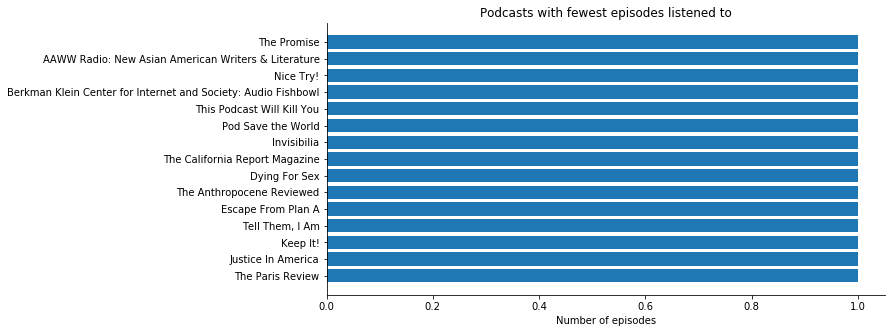

In [23]:
show_episode_counts = podcast_df.groupby('show_name').count().sort_values(by='episode_title')['episode_title']
show_episode_counts_low = show_episode_counts[:15]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_episode_counts_low.index,show_episode_counts_low.values)
plt.xlabel('Number of episodes')
plt.title('Podcasts with fewest episodes listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

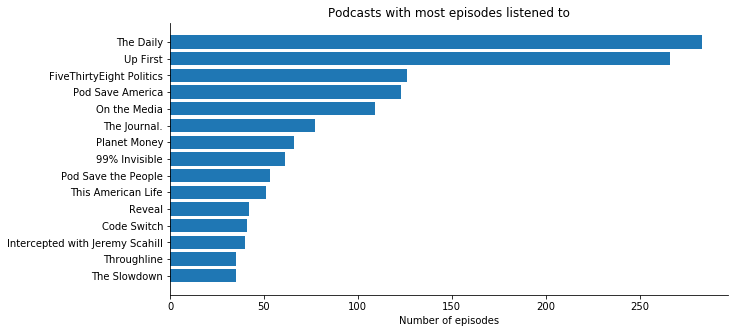

In [24]:
show_episode_counts_high = show_episode_counts[-15:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_episode_counts_high.index,show_episode_counts_high.values)
plt.xlabel('Number of episodes')
plt.title('Podcasts with most episodes listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The median number of podcast episodes I've listened to per show is 6.0
         The mean number of podcast episodes I've listened to per show is 19.533333333333335
         The standard deviation of number of podcast episodes I've listened to per show is 42.772894604182596


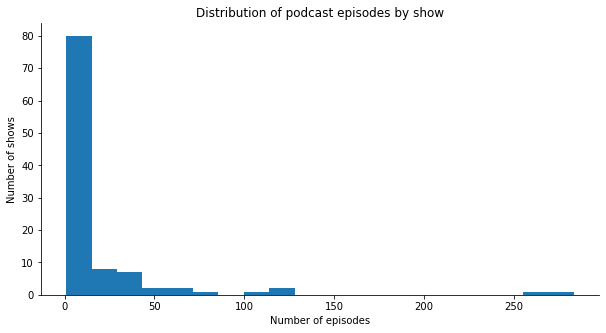

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(show_episode_counts,bins=20)
plt.xlabel('Number of episodes')
plt.ylabel('Number of shows')
plt.title('Distribution of podcast episodes by show')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median number of podcast episodes I've listened to per show is {}\n \
        The mean number of podcast episodes I've listened to per show is {}\n \
        The standard deviation of number of podcast episodes I've listened to per show is {}".format(show_episode_counts.median(), show_episode_counts.mean(), show_episode_counts.std()))

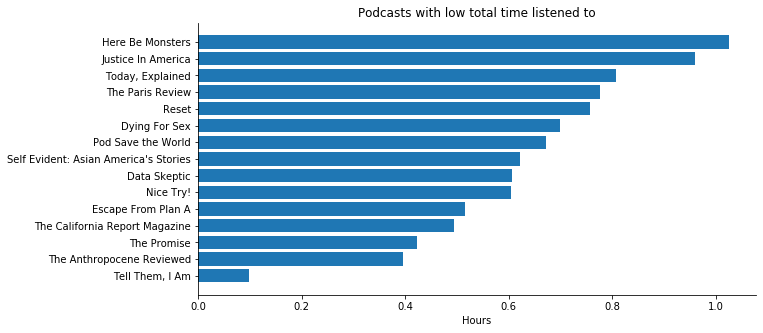

In [26]:
show_durations = podcast_df.groupby('show_name').agg({'duration_seconds': sum}).sort_values(by='duration_seconds')['duration_seconds']/3600
show_durations_low = show_durations[:15]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_durations_low.index,show_durations_low.values)
plt.xlabel('Hours')
plt.title('Podcasts with low total time listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

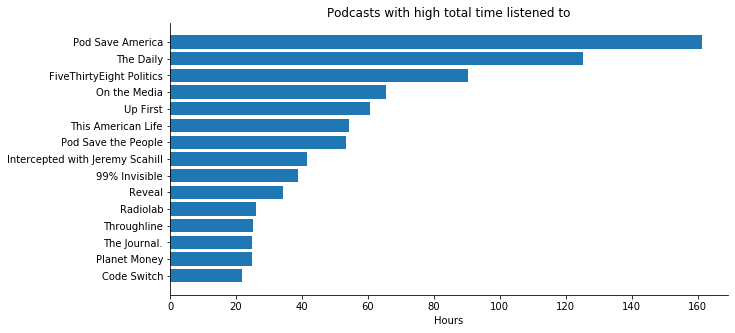

In [27]:
show_durations_high = show_durations[-15:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_durations_high.index,show_durations_high.values)
plt.xlabel('Hours')
plt.title('Podcasts with high total time listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The median of total time of show I've listened to per show is 3.262777777777778
         The mean of total time of show I've listened to per show is 11.529082010582009
         The standard deviation of total time of show I've listened to per show is 24.04483978449914


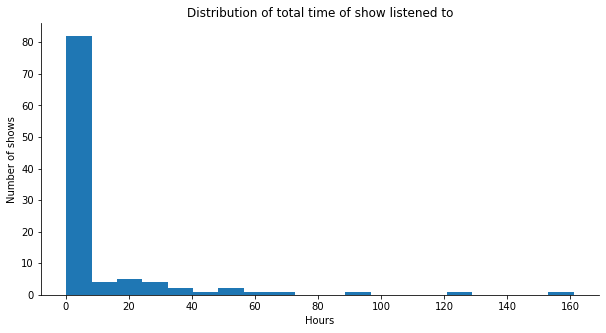

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(show_durations,bins=20)
plt.xlabel('Hours')
plt.ylabel('Number of shows')
plt.title('Distribution of total time of show listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of total time of show I've listened to per show is {}\n \
        The mean of total time of show I've listened to per show is {}\n \
        The standard deviation of total time of show I've listened to per show is {}".format(show_durations.median(), show_durations.mean(), show_durations.std()))

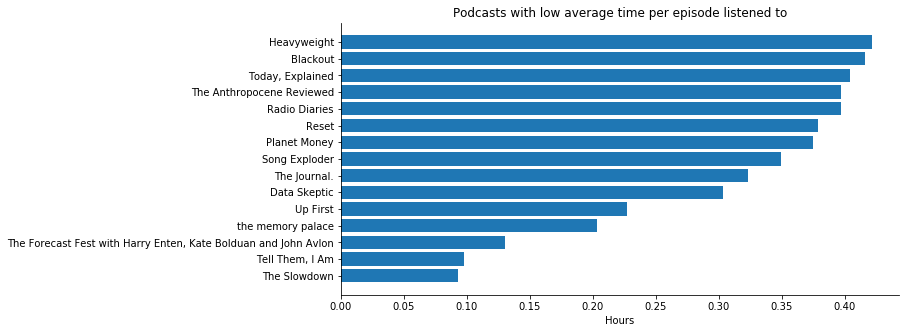

In [29]:
mean_show_durations = podcast_df.groupby('show_name').agg({'duration_seconds': np.mean}).sort_values(by='duration_seconds')['duration_seconds']/3600
mean_show_durations_low = mean_show_durations[:15]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(mean_show_durations_low.index,mean_show_durations_low.values)
plt.xlabel('Hours')
plt.title('Podcasts with low average time per episode listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

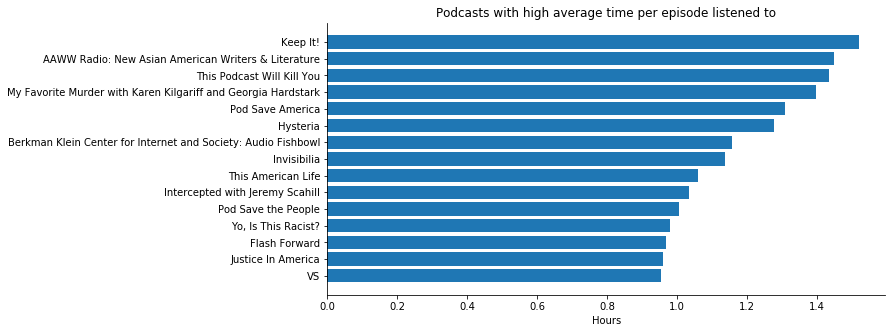

In [30]:
mean_show_durations_high = mean_show_durations[-15:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(mean_show_durations_high.index,mean_show_durations_high.values)
plt.xlabel('Hours')
plt.title('Podcasts with high average time per episode listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The median of average time of show I've listened to per episode is 0.6055555555555555 hours
         The mean of average time of show I've listened to per episode is 0.6512734016185541 hours
         The standard deviation of average time of show I've listened to per episode is 0.27578878684233354 hours


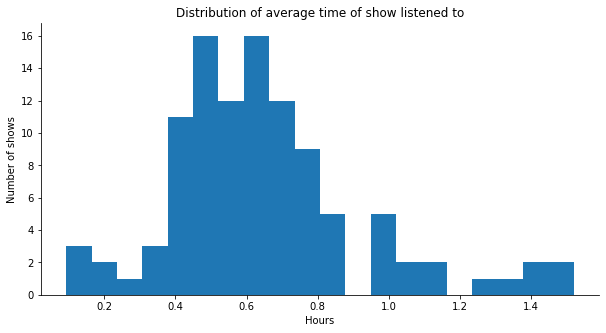

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(mean_show_durations,bins=20)
plt.xlabel('Hours')
plt.ylabel('Number of shows')
plt.title('Distribution of average time of show listened to')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of average time of show I've listened to per episode is {} hours\n \
        The mean of average time of show I've listened to per episode is {} hours\n \
        The standard deviation of average time of show I've listened to per episode is {} hours".format(mean_show_durations.median(), mean_show_durations.mean(), mean_show_durations.std()))

In [32]:
mean_durations_by_month = podcast_df.groupby('release_date_year_month').agg({'duration_seconds': sum})['duration_seconds']/3600
mean_durations_by_month

release_date_year_month
2016-03      1.999722
2016-04      1.791111
2016-06      1.253056
2016-11      0.192500
2017-01      0.588333
2017-05      0.499722
2017-06      0.171389
2017-10      1.731667
2017-11      1.396667
2017-12      4.038889
2018-01      1.020833
2018-04      1.034167
2018-05      3.418611
2018-06      0.669722
2018-07      4.046944
2018-08      4.391667
2018-09      6.132222
2018-10     12.038611
2018-11     11.634444
2018-12      7.038889
2019-01      7.129444
2019-02      6.384722
2019-03     63.865556
2019-04     78.692778
2019-05     93.985000
2019-06     91.403056
2019-07     87.116389
2019-08     82.346667
2019-09     85.944722
2019-10     87.858889
2019-11     88.819167
2019-12     86.075833
2020-01    102.809722
2020-02    113.871667
2020-03     69.160833
Name: duration_seconds, dtype: float64

In [33]:
mean_durations_by_month.values

array([  1.99972222,   1.79111111,   1.25305556,   0.1925    ,
         0.58833333,   0.49972222,   0.17138889,   1.73166667,
         1.39666667,   4.03888889,   1.02083333,   1.03416667,
         3.41861111,   0.66972222,   4.04694444,   4.39166667,
         6.13222222,  12.03861111,  11.63444444,   7.03888889,
         7.12944444,   6.38472222,  63.86555556,  78.69277778,
        93.985     ,  91.40305556,  87.11638889,  82.34666667,
        85.94472222,  87.85888889,  88.81916667,  86.07583333,
       102.80972222, 113.87166667,  69.16083333])

The median of average time of show I've listened to by show release date months is 6.384722222222222 hours
         The mean of average time of show I've listened to by show release date months is 34.587246031746034 hours
         The standard deviation of average time of show I've listened to by show release date months is 41.735377473969855 hours


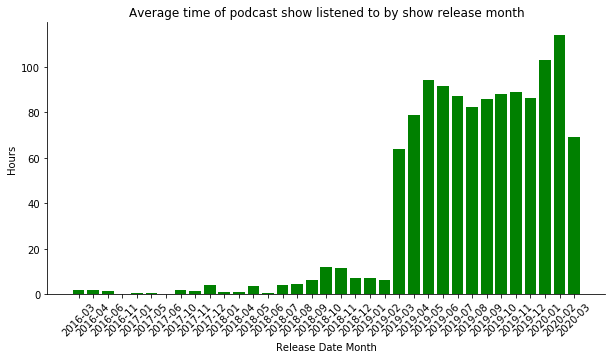

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(mean_durations_by_month.index,mean_durations_by_month.values, color= 'g')

plt.xlabel('Release Date Month')
plt.xticks(rotation=45)
plt.ylabel('Hours')
plt.title('Average time of podcast show listened to by show release month')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of average time of show I've listened to by show release date months is {} hours\n \
        The mean of average time of show I've listened to by show release date months is {} hours\n \
        The standard deviation of average time of show I've listened to by show release date months is {} hours".format(mean_durations_by_month.median(), mean_durations_by_month.mean(), mean_durations_by_month.std()))

In [35]:
total_duration_by_played_month = podcast_df.groupby('last_played_year_month').agg({'duration_seconds': sum})['duration_seconds']/3600
total_duration_by_played_month

last_played_year_month
2019-03     71.504444
2019-04     71.163333
2019-05     75.861111
2019-06     90.197500
2019-07     82.859722
2019-08     86.057222
2019-09     83.433333
2019-10     97.200000
2019-11    100.429444
2019-12     88.336667
2020-01    103.738056
2020-02    167.337500
2020-03     92.435278
Name: duration_seconds, dtype: float64

The median of average time of show I've listened to by month of listening is 88.33666666666667 hours
         The mean of average time of show I've listened to by month of listening is 93.11950854700855 hours
         The standard deviation of average time of show I've listened to by month of listening is 24.527415364272834 hours


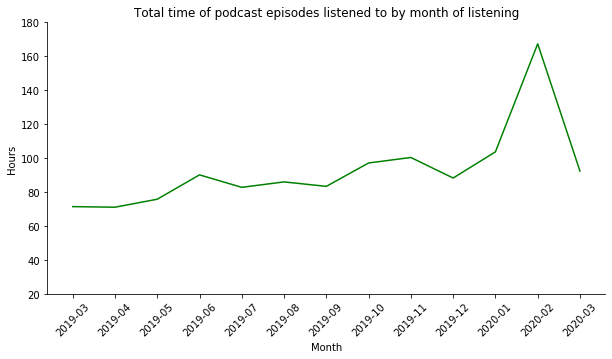

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(total_duration_by_played_month.index,total_duration_by_played_month.values, color= 'g')

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Hours')
plt.ylim(20,180)
plt.title('Total time of podcast episodes listened to by month of listening')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of average time of show I've listened to by month of listening is {} hours\n \
        The mean of average time of show I've listened to by month of listening is {} hours\n \
        The standard deviation of average time of show I've listened to by month of listening is {} hours".format(total_duration_by_played_month.median(), total_duration_by_played_month.mean(), total_duration_by_played_month.std()))

In [37]:
def number_of_days_in_month(yearmonth):
    year = int(yearmonth[:4])
    month = int(yearmonth[5:])
    return calendar.monthrange(year,month)[1]

In [38]:
total_duration_by_played_month = podcast_df.groupby('last_played_year_month').agg({'duration_seconds': sum}).reset_index()
total_duration_by_played_month['days_per_month'] = total_duration_by_played_month['last_played_year_month'].apply(lambda row: number_of_days_in_month(row))

In [39]:
total_duration_by_played_month['normalized_hours'] = total_duration_by_played_month['duration_seconds']/(total_duration_by_played_month['days_per_month'] * 3600)

The median of average time of show I've listened to by month of listening is 2.8495698924731183 hours
         The mean of average time of show I've listened to by month of listening is 3.0610461093205807 hours
         The standard deviation of average time of show I've listened to by month of listening is 0.880051022257794 hours


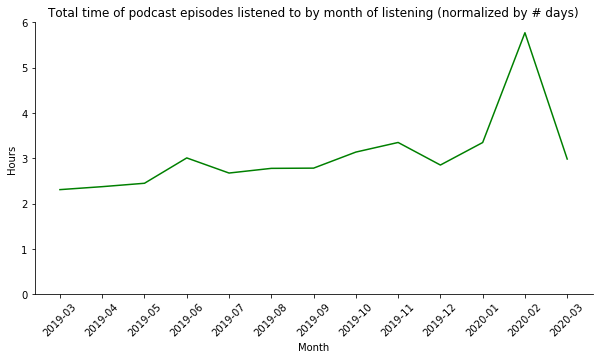

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(total_duration_by_played_month['last_played_year_month'],total_duration_by_played_month['normalized_hours'], color= 'g')

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Hours')
plt.ylim(0,6)
plt.title('Total time of podcast episodes listened to by month of listening (normalized by # days)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of average time of show I've listened to by month of listening is {} hours\n \
        The mean of average time of show I've listened to by month of listening is {} hours\n \
        The standard deviation of average time of show I've listened to by month of listening is {} hours".format(total_duration_by_played_month['normalized_hours'].median(), total_duration_by_played_month['normalized_hours'].mean(), total_duration_by_played_month['normalized_hours'].std()))

In [42]:
weekday_to_idx = {v: k for k, v in date_to_weekday.items()}
total_duration_by_played_DOW = podcast_df.groupby('last_played_DOW').agg({'duration_seconds': sum}).reset_index()
total_duration_by_played_DOW['last_played_DOW_idx'] = total_duration_by_played_DOW['last_played_DOW'].apply(lambda row: weekday_to_idx[row])
total_duration_by_played_DOW = total_duration_by_played_DOW.sort_values(by='last_played_DOW_idx')
total_duration_by_played_DOW

,last_played_DOW,duration_seconds,last_played_DOW_idx
1,Monday,706507.0,0
5,Tuesday,708759.0,1
6,Wednesday,583968.0,2
4,Thursday,665368.0,3
0,Friday,615719.0,4
2,Saturday,438118.0,5
3,Sunday,639554.0,6


In [43]:
time_difference = podcast_df['last_played'].max() - podcast_df['last_played'].min()
first_DOW = podcast_df['last_played'].min().weekday()
last_DOW = podcast_df['last_played'].max().weekday()
num_weeks = (time_difference/7).days

In [44]:
def counts_per_DOW(day1,day2,num_weeks):
    day_counts = {day: num_weeks for day in date_to_weekday.values()
                 }
    day = day1
    while (day % 7) != day2:
        day_counts[date_to_weekday[day % 7]] += 1
        day += 1
    day_counts[date_to_weekday[day % 7]] += 1
    return day_counts

In [46]:
counts_DOW = counts_per_DOW(first_DOW, last_DOW, num_weeks)
total_duration_by_played_DOW['count_DOW'] = total_duration_by_played_DOW['last_played_DOW'].apply(lambda row: counts_DOW[row])
total_duration_by_played_DOW['normalized_hours'] = total_duration_by_played_DOW['duration_seconds']/(total_duration_by_played_DOW['count_DOW'] * 3600)
total_duration_by_played_DOW

,last_played_DOW,duration_seconds,last_played_DOW_idx,count_DOW,normalized_hours
1,Monday,706507.0,0,54,3.634295
5,Tuesday,708759.0,1,54,3.645880
6,Wednesday,583968.0,2,53,3.060629
4,Thursday,665368.0,3,54,3.422675
0,Friday,615719.0,4,54,3.167279
2,Saturday,438118.0,5,54,2.253693
3,Sunday,639554.0,6,54,3.289887


The median of average time of show I've listened to by day of week of listening is 3.2898868312757203 hours
         The mean of average time of show I've listened to by day of week of listening is 3.210619682650605 hours
         The standard deviation of average time of show I've listened to by day of week of listening is 0.4761453656080329 hours


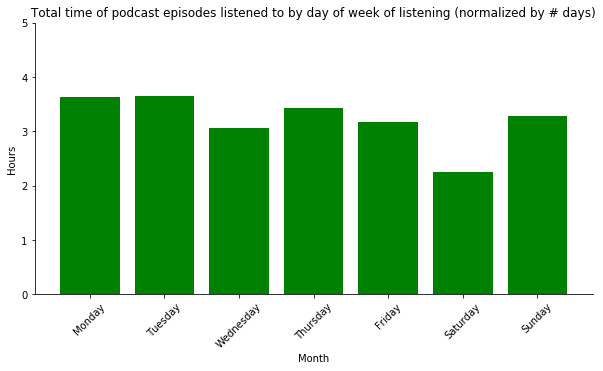

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(total_duration_by_played_DOW['last_played_DOW'],total_duration_by_played_DOW['normalized_hours'], color= 'g')

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.ylabel('Hours')
plt.ylim(0,5)
plt.title('Total time of podcast episodes listened to by day of week of listening (normalized by # days)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of average time of show I've listened to by day of week of listening is {} hours\n \
        The mean of average time of show I've listened to by day of week of listening is {} hours\n \
        The standard deviation of average time of show I've listened to by day of week of listening is {} hours".format(total_duration_by_played_DOW['normalized_hours'].median(), total_duration_by_played_DOW['normalized_hours'].mean(), total_duration_by_played_DOW['normalized_hours'].std()))

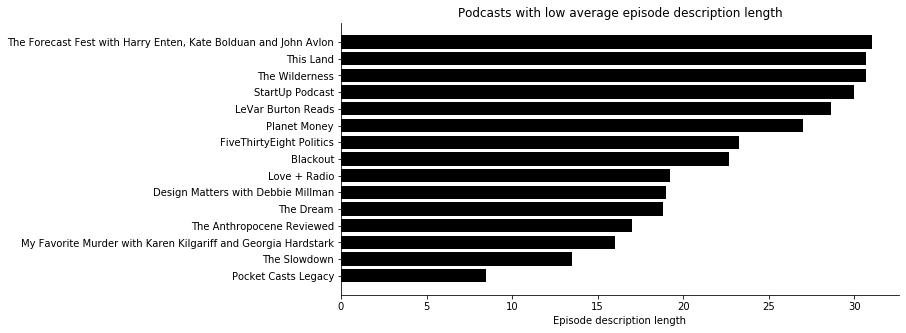

In [48]:
show_episode_total_lengths = podcast_df.groupby('show_name').mean().sort_values(by='episode_description_len')['episode_description_len']
show_episode_total_lengths_low = show_episode_total_lengths[:15]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_episode_total_lengths_low.index,show_episode_total_lengths_low.values,color='k')
plt.xlabel('Episode description length')
plt.title('Podcasts with low average episode description length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

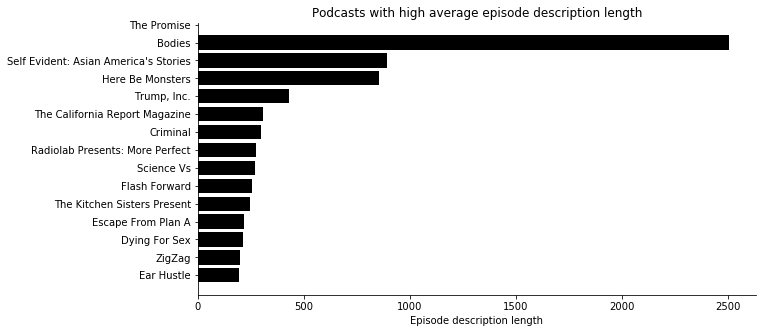

In [49]:
show_episode_total_lengths_high = show_episode_total_lengths[-15:]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_episode_total_lengths_high.index,show_episode_total_lengths_high.values,color='k')
plt.xlabel('Episode description length')
plt.title('Podcasts with high average episode description length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/home/derek/anaconda3/envs/working/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/derek/anaconda3/envs/working/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


The median of averge episode description lengths I've listened to per show is 78.05128205128204
         The mean of averge episode description lengths I've listened to per show is 137.19973821663777
         The standard deviation of averge episode description lengths I've listened to per show is 268.2444532847237


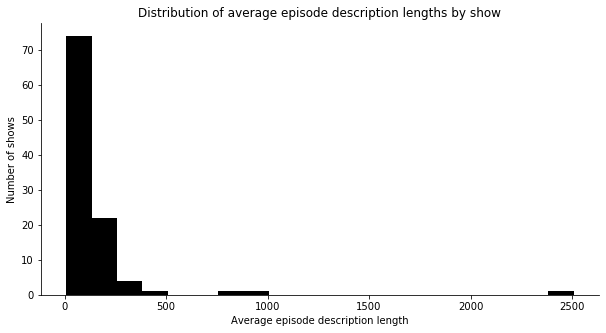

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(show_episode_total_lengths,bins=20,color='k')
plt.xlabel('Average episode description length')
plt.ylabel('Number of shows')
plt.title('Distribution of average episode description lengths by show')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of averge episode description lengths I've listened to per show is {}\n \
        The mean of averge episode description lengths I've listened to per show is {}\n \
        The standard deviation of averge episode description lengths I've listened to per show is {}".format(show_episode_total_lengths.median(), show_episode_total_lengths.mean(), show_episode_total_lengths.std()))

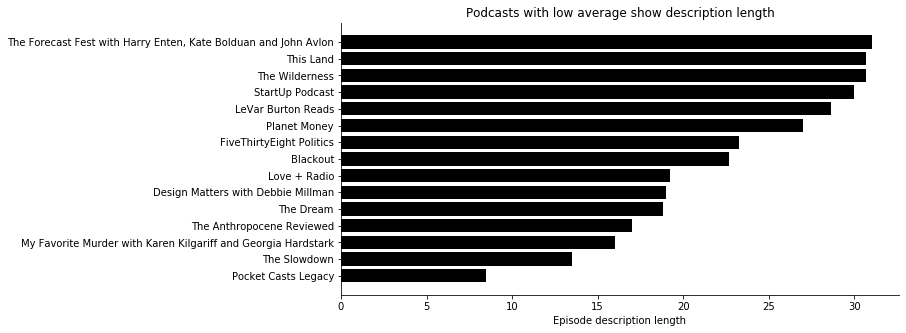

In [51]:
show_description_total_lengths = podcast_df.groupby('show_name').agg({'show_description_len':np.nanmean}).sort_values(by='show_description_len')['show_description_len']
show_description_total_lengths = show_description_total_lengths.loc[show_description_total_lengths.index != 'Pocket Casts Legacy']

show_description_total_lengths_low = show_episode_total_lengths[:15]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_description_total_lengths_low.index,show_description_total_lengths_low.values,color='k')
plt.xlabel('Episode description length')
plt.title('Podcasts with low average show description length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

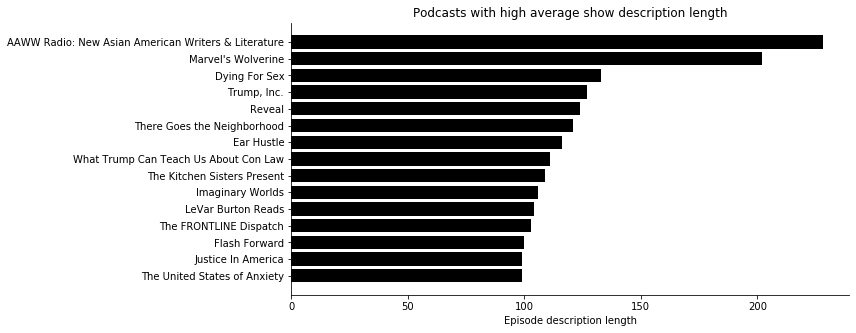

In [52]:
show_description_total_lengths_high = show_description_total_lengths[-15:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(show_description_total_lengths_high.index,show_description_total_lengths_high.values,color='k')
plt.xlabel('Episode description length')
plt.title('Podcasts with high average show description length')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The median of averge show description lengths I've listened to per show is 55.0
         The mean of averge show description lengths I've listened to per show is 62.11538461538461
         The standard deviation of averge show description lengths I've listened to per show is 36.830313520595936


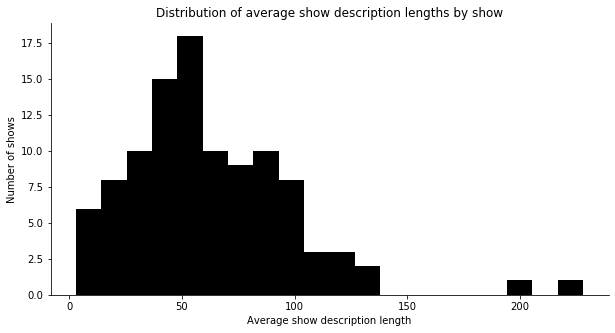

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(show_description_total_lengths,bins=20,color='k')
plt.xlabel('Average show description length')
plt.ylabel('Number of shows')
plt.title('Distribution of average show description lengths by show')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

print("The median of averge show description lengths I've listened to per show is {}\n \
        The mean of averge show description lengths I've listened to per show is {}\n \
        The standard deviation of averge show description lengths I've listened to per show is {}".format(show_description_total_lengths.median(), show_description_total_lengths.mean(), show_description_total_lengths.std()))

## Show-level text description exploration

# To Do:

- Try other HTML parsing methodologies
- Make a vocab of all of the show-description documents and do some stats on that, maybe a word cloud (which are not particularly useful, but kind of fun)
- Clustering of show-description documents
- Make a vocab of all of the episode-description documents and do some stats on that, maybe a word cloud
- Clustering on episode-description documents 